In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#giai nen file zip
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/FinalProject_cs114/Testfolder/Quang.zip",'r') as zip_ref:
  zip_ref.extractall("/content/drive/MyDrive/FinalProject_cs114/Testfolder")

In [ ]:
#khai bao cac thu vien can thiet
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil as sh
import torch
import copy
import math
from google.colab.patches import cv2_imshow

from tqdm.auto import tqdm
from IPython.display import Image, clear_output
%matplotlib inline

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16383, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 16383 (delta 138), reused 158 (delta 74), pack-reused 16106
Receiving objects: 100% (16383/16383), 15.16 MiB | 15.46 MiB/s, done.
Resolving deltas: 100% (11175/11175), done.


In [ ]:
!pip install -r /content/yolov5/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.8/702.8 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.2.0 which is incompatible.


In [ ]:
yolo_LP_detect = torch.hub.load('yolov5', 'custom', path='/content/drive/MyDrive/FinalProject_cs114/model_trained/LP.pt', force_reload=True, source='local')
yolo_license_plate = torch.hub.load('yolov5', 'custom', path='/content/drive/MyDrive/FinalProject_cs114/model_trained/OCR.pt', force_reload=True, source='local')

YOLOv5 🚀 v7.0-278-g050c72c Python-3.10.12 torch-2.1.0+cu121 CPU

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 v7.0-278-g050c72c Python-3.10.12 torch-2.1.0+cu121 CPU

Fusing layers... 
Model summary: 212 layers, 20970123 parameters, 0 gradients, 48.2 GFLOPs
Adding AutoShape... 




CÁC HÀM XỬ LÝ ẢNH SAU ĐÂY ĐỂ GIÚP TĂNG HIỆU SUẤT CỦA MÔ HÌNH

1.THAY ĐỔI ĐỘ TƯƠNG PHẢN CỦA HÌNH ẢNH:
- Việc thay đổi này giúp nổi bật lên các chi tiết, tăng cường sự phân biệt giữa các đối tượng. Chung quy lại để tăng khả năng nhận diện của mô hình.


Thực hiện:
  - Đầu tiên, sẽ thay đổi hình ảnh ở không gian màu BGR về không gian màu LAB (LAB là một không gian màu không gian màu không chứa thông tin về màu sắc mà không chứa thông tin về độ sáng (L là chiều sáng - Lightness, A và B là chiều màu).)


In [ ]:
img_path = '/content/drive/MyDrive/FinalProject_cs114/crop/crop0.jpg'

img = cv2.imread(img_path)


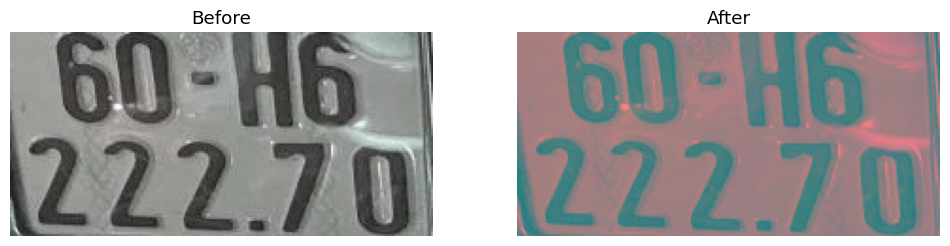

In [ ]:
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
fig,axes = plt.subplots(1,2,figsize = (12,6))
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title("Before")
axes[1].imshow(img_lab)
axes[1].axis('off')
axes[1].set_title("After")
plt.show()

  - Tiếp theo, chúng ta phân tách cách kênh

In [ ]:
l, a, b = cv2.split(img_lab)
print('l:',l)
print('a:',a)
print('b:',b)


l: [[170 169 170 ...  60  41 204]
 [168 168 169 ...  78  42 196]
 [166 165 167 ...  97  46 186]
 ...
 [ 96  99 126 ... 128 114 160]
 [ 88  95  94 ... 128 113 174]
 [ 86  88  87 ... 128 107 181]]
a: [[125 125 125 ... 125 126 125]
 [125 125 125 ... 126 125 125]
 [125 125 125 ... 126 125 126]
 ...
 [126 126 126 ... 126 126 126]
 [126 126 126 ... 126 126 126]
 [126 126 126 ... 126 126 126]]
b: [[130 129 130 ... 132 132 132]
 [129 129 129 ... 131 132 132]
 [129 130 129 ... 131 132 131]
 ...
 [134 134 134 ... 132 132 132]
 [134 134 134 ... 132 132 132]
 [134 134 134 ... 132 132 132]]


  - Tiếp theo, Áp dụng CLAHE cho kênh L rồi trộn lại và chuyển lại sang RGB:
  
  CLAHE là viết tắt của "Contrast Limited Adaptive Histogram Equalization" trong tiếng Anh. Trong tiếng Việt, nó được dịch là "Cân bằng Histogram Độ tương phản Hạn chế và Linh hoạt". Đây là một phương pháp xử lý hình ảnh được sử dụng để cải thiện độ tương phản trong các hình ảnh.

  CLAHE hoạt động bằng cách chia hình ảnh thành các khu vực nhỏ, gọi là ô, và áp dụng hiệu chỉnh độ tương phản riêng lẻ cho từng ô dựa trên histogram của ô đó. Nó giúp giảm thiểu việc mất mát thông tin trong các khu vực cực sáng hoặc cực tối của hình ảnh và cân bằng độ tương phản một cách linh hoạt.

  1. clipLimit: Đây là giới hạn trên cho hiệu chỉnh độ tương phản. Nó xác định mức độ giới hạn cho việc cải thiện độ tương phản trong các khu vực nhỏ. Giá trị lớn hơn sẽ dẫn đến mức độ tương phản cao hơn, nhưng cũng có thể dẫn đến hiện tượng "noise".

  2. tileGridSize: Kích thước của các ô lưới được sử dụng để chia ảnh thành các phần nhỏ. CLAHE được áp dụng cho mỗi phần nhỏ này riêng biệt. tileGridSize quy định số lượng ô theo chiều ngang và chiều dọc trong lưới. Đối với ví dụ trên, là (8, 8), có nghĩa là ảnh sẽ được chia thành các ô 8x8.
  


[[173 170 173 ...  35  11 245]
 [166 166 170 ...  50  14 242]
 [160 157 163 ...  62  19 229]
 ...
 [119 121 150 ... 168 134 229]
 [107 116 114 ... 168 131 254]
 [103 107 104 ... 168 120 255]]


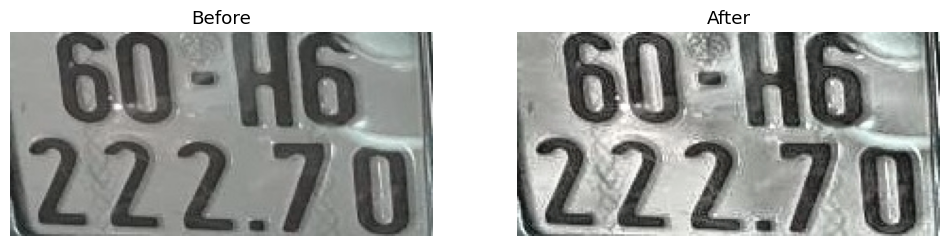

In [ ]:
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
cl = clahe.apply(l)
img_temp = cv2.merge((cl,a,b))
changed_img = cv2.cvtColor(img_temp, cv2.COLOR_LAB2BGR)

fig,axes = plt.subplots(1,2,figsize = (12,6))
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title("Before")
axes[1].imshow(changed_img)
axes[1].axis('off')
axes[1].set_title("After")
print(cl)
plt.show()

Hàm changeContrast sau khi kết hợp lại:

In [ ]:
def changeContrast(img):
    img_lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(img_lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    img_temp = cv2.merge((cl,a,b))
    changed_img = cv2.cvtColor(img_temp, cv2.COLOR_LAB2BGR)
    return changed_img

2.XOAY HÌNH ẢNH:

  Đầu tiên, tìm điểm trung tâm của ảnh (Lấy chiều cao và chiều rộng của anhe chia 2)

In [ ]:
img_path = '/content/drive/MyDrive/FinalProject_cs114/crop/crop0.jpg'

img = cv2.imread(img_path)

In [ ]:
img_center = tuple(np.array(img.shape[1::-1]) / 2)

Tiếp theo, tạo ma trận xoay 2D dựa trên tâm của hình ảnh và góc xoay bằng lệnh cv2.getRotationMatrix2D(trung tâm ảnh(x,y), ảnh, scale)

Sau đó, sử dụng hàm cv2.warpAffine để thực hiện phép biến đổi affine (trong trường hợp này là xoay) trên hình ảnh. Dưới đây là giải thích các tham số của hàm này:

img: Hình ảnh cần được biến đổi.

rot_mat: Ma trận xoay đã tính toán từ cv2.getRotationMatrix2D.

img.shape[1::-1]: Kích thước của hình ảnh sau khi xoay, chuyển đổi từ (chiều rộng, chiều cao) sang (chiều cao, chiều rộng).

flags=cv2.INTER_LINEAR: Phương pháp nội suy được sử dụng khi thực hiện biến đổi. Trong trường hợp này, cv2.INTER_LINEAR sử dụng phương pháp nội suy tuyến tính để xác định giá trị của các điểm ảnh mới.

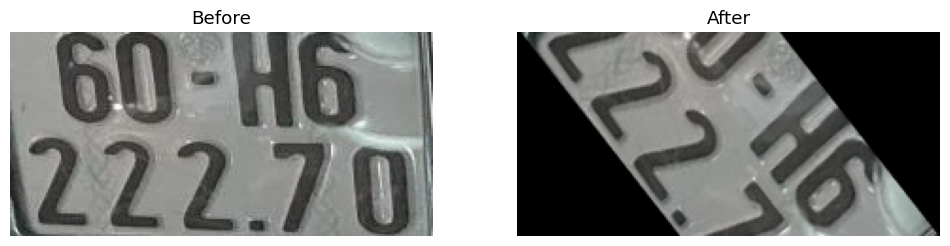

In [ ]:
angle = -52
rot_mat = cv2.getRotationMatrix2D(img_center, angle, 1.0)
result = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)

fig,axes = plt.subplots(1,2,figsize = (12,6))
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title("Before")
axes[1].imshow(result)
axes[1].axis('off')
axes[1].set_title("After")
plt.show()

Hàm rotateImage sau khi kết hợp lại:

In [ ]:
def rotateImage(img, angle):
    img_center = tuple(np.array(img.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(img_center, angle, 1.0)
    result = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

3.TÍNH TOÁN ĐỘ NGHIÊNG:

Tính chiều cao và chiều rộng:
Nếu hình ảnh có 3 kênh màu (3D), giá trị h, w, _ được gán từ src_img.shape.

Nếu hình ảnh có 1 kênh màu (ảnh đen trắng, 2D), giá trị h, w được gán từ src_img.shape.

Nếu hình ảnh không phải là ảnh màu hoặc đen trắng, in ra thông báo lỗi và trả về 1.

Làm mờ hình ảnh:

Hình ảnh được làm mờ bằng phương pháp trung bình (cv2.medianBlur) với kernel size là 3.

Phát hiện cạnh:

Sử dụng phương pháp Canny để phát hiện cạnh trong hình ảnh (cv2.Canny).


Phát hiện đường thẳng bằng phương pháp Hough:

Sử dụng phương pháp Hough để phát hiện các đường thẳng trong hình ảnh (cv2.HoughLinesP).

Nếu không tìm thấy đường thẳng nào, trả về 1.

Tính toán góc nghiêng:

Xác định đường thẳng nằm gần tâm và không bị ảnh hưởng bởi giới hạn dưới (center_thres).

Tính toán góc nghiêng của đường thẳng bằng cách sử dụng arctan2 (np.arctan2).

Lọc bỏ những góc quá lớn (30 độ) để loại bỏ các xoay cực đoan.

Tính trung bình góc nghiêng và trả về kết quả theo đơn vị độ.



Tính chiều cao chiều rộng

In [ ]:
img_path = '/content/drive/MyDrive/FinalProject_cs114/crop/crop0.jpg'

img = cv2.imread(img_path)

In [ ]:
if len(img.shape) == 3:
    h, w, _ = img.shape
elif len(img.shape) == 2:
    h, w = img.shape
else:
    print('upsupported image type')

Làm mờ hình ảnh: Dùng để giảm nhiễu, giảm độ nhạy cảm đối với đối tượng nhỏ, giảm các đường nhiễu, cải thiện kết quả phát hiện cạnh.

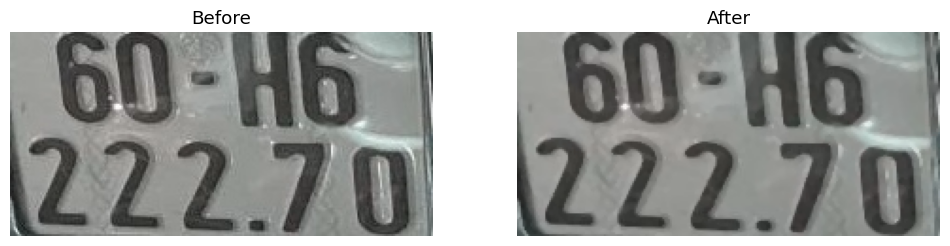

In [ ]:
blured_img = cv2.medianBlur(img, 3)

fig,axes = plt.subplots(1,2,figsize = (12,6))
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title("Before")
axes[1].imshow(blured_img)
axes[1].axis('off')
axes[1].set_title("After")
plt.show()

Phát hiện cạnh bằng cách sử dụng hàm Canny trong cv2

Dưới đây là giải thích về các tham số được sử dụng trong hàm này:

- img: Hình ảnh nguồn mà bạn muốn phát hiện cạnh.

- threshold1: Ngưỡng dưới cho quá trình phát hiện cạnh. Bất kỳ giá trị gradient dưới ngưỡng này sẽ bị loại bỏ.

- threshold2: Ngưỡng trên cho quá trình phát hiện cạnh. Bất kỳ giá trị gradient lớn hơn ngưỡng này sẽ được coi là một cạnh.

- apertureSize: Kích thước của bộ lọc Sobel được sử dụng để tính đạo hàm của ảnh. Kích thước này liên quan đến việc xác định độ chính xác của đạo hàm, và nó ảnh hưởng đến hiệu suất của quá trình phát hiện cạnh.

- L2gradient: Một cờ boolean quyết định phương pháp tính toán độ lớn của gradient. Nếu True, nó sử dụng sqrt(dx^2 + dy^2) để tính toán độ lớn, nếu False, nó sử dụng abs(dx) + abs(dy).

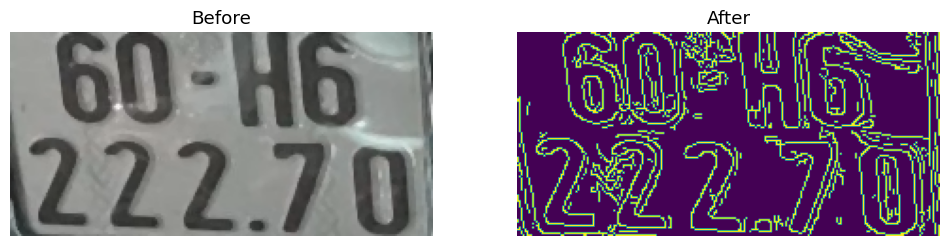

In [ ]:
edges = cv2.Canny(img,  threshold1 = 30,  threshold2 = 100, apertureSize = 3, L2gradient = True)
fig,axes = plt.subplots(1,2,figsize = (12,6))
axes[0].imshow(blured_img)
axes[0].axis('off')
axes[0].set_title("Before")
axes[1].imshow(edges)
axes[1].axis('off')
axes[1].set_title("After")
plt.show()

Phát hiện các đường thằng bằng phương pháp Hough. Dưới đây là giải thích về các tham số được sử dụng trong hàm này:

- edges: Hình ảnh đã được làm mờ và phát hiện cạnh (thường được tạo bằng phương pháp Canny).

- 1: ρ (rho) là độ đo của đường thẳng từ tâm ảnh đến đường thẳng, thường được đặt là 1 pixel.

- math.pi/180: θ (theta) là độ đo của góc giữa đường thẳng và trục hoành (tính bằng radian).

- 30: Ngưỡng, là số lượng phiếu bình chọn (votes) cần thiết để xác định một đường thẳng. Các đường thẳng có số phiếu lớn hơn ngưỡng này sẽ được chấp nhận.

- minLineLength=w / 1.5: Độ dài tối thiểu của đường thẳng để được chấp nhận. Các đoạn thẳng ngắn hơn sẽ bị loại bỏ.

- maxLineGap=h/3.0: Khoảng cách tối đa được phép giữa các đoạn thẳng để chúng được kết hợp thành một đường thẳng duy nhất.

[[[  3 107 220  99]]

 [[ 24   9 208   0]]

 [[  0  66 223  54]]

 [[ 42   9 222  15]]

 [[ 25  18 222  12]]

 [[ 32   0 222  69]]

 [[  0 100 155 106]]

 [[  2  55 222  16]]

 [[ 24  10 222  70]]

 [[  1  89 222  18]]

 [[  2  79 222  44]]

 [[ 25   0 223   7]]

 [[  2  94 215 102]]

 [[ 25  16 223   6]]

 [[ 26  27 222  13]]

 [[  2  95 155   0]]

 [[  1  51 223   0]]

 [[  1  91 223  48]]

 [[ 45 107 215 101]]

 [[  2  78 223  31]]

 [[ 25  17 221  10]]

 [[ 24  11 213  77]]

 [[  4  65 220  19]]

 [[  1  43 207  21]]

 [[  2 105 221   3]]

 [[ 40  23 201  81]]

 [[  2  53 214  87]]

 [[ 27  30 200  96]]

 [[ 24   6 223   9]]

 [[  0  68 222  64]]

 [[  5  43 186   7]]

 [[  1  72 208  65]]

 [[  1 103 218  95]]

 [[ 70  85 221  56]]

 [[ 39   0 217   0]]

 [[  0  89 187  53]]

 [[  1  37 221  53]]

 [[ 24   7 218  11]]

 [[ 52  89 203 107]]

 [[ 24   8 221  61]]

 [[  6  95 156 103]]

 [[  3  60 196  16]]]


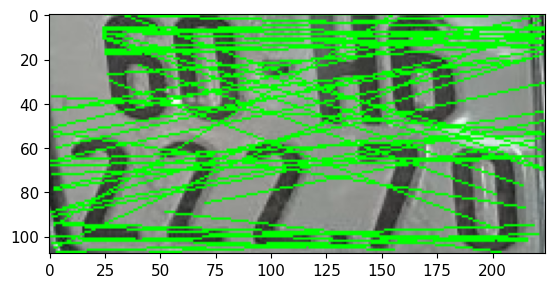

In [ ]:
lines = cv2.HoughLinesP(edges, 1, math.pi/180, 30, minLineLength=w / 1.5, maxLineGap=h/3.0)
print (lines)
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 1)
plt.imshow(img)
plt.show()


Sau khi đã có được tọa độ của các đường thẳng, giờ chúng ta sẽ kiểm tra xem các đường thẳng này đường thẳng nào là cạnh ở trên cùng và là cạnh của biển báo thì từ đó tính được độ nghiêng.

In [ ]:
center_thres = 1
min_line = 100
min_line_pos = 0
for i in range (len(lines)):
    for x1, y1, x2, y2 in lines[i]:
        center_point = [((x1+x2)/2), ((y1+y2)/2)]
        if center_thres == 1:
            if center_point[1] < 7:
                    continue
        if center_point[1] < min_line:
            min_line = center_point[1]
            min_line_pos = i

angle = 0.0
nlines = lines.size
cnt = 0
for x1, y1, x2, y2 in lines[min_line_pos]:
    ang = np.arctan2(y2 - y1, x2 - x1)
    if math.fabs(ang) <= 30:
        angle += ang
        cnt += 1
print (angle)
print(cnt)
print((angle / cnt)*180/math.pi)

0.015074234994959463
1
0.863690044599587


Hàm compute_skew (tính góc nghiêng):

In [ ]:
def compute_skew(src_img, center_thres):
    if len(src_img.shape) == 3:
        h, w, _ = src_img.shape
    elif len(src_img.shape) == 2:
        h, w = src_img.shape
    else:
        print('upsupported image type')
    img = cv2.medianBlur(src_img, 3)
    edges = cv2.Canny(img,  threshold1 = 30,  threshold2 = 100, apertureSize = 3, L2gradient = True)
    lines = cv2.HoughLinesP(edges, 1, math.pi/180, 30, minLineLength=w / 1.5, maxLineGap=h/3.0)
    if lines is None:
        return 1

    min_line = 100
    min_line_pos = 0
    for i in range (len(lines)):
        for x1, y1, x2, y2 in lines[i]:
            center_point = [((x1+x2)/2), ((y1+y2)/2)]
            if center_thres == 1:
                if center_point[1] < 7:
                    continue
            if center_point[1] < min_line:
                min_line = center_point[1]
                min_line_pos = i

    angle = 0.0
    cnt = 0
    for x1, y1, x2, y2 in lines[min_line_pos]:
        ang = np.arctan2(y2 - y1, x2 - x1)
        if math.fabs(ang) <= 30:
            angle += ang
            cnt += 1
    if cnt == 0:
        return 0.0
    return (angle / cnt)*180/math.pi

Hàm tổng quát với tất cả các chức năng:

In [ ]:
def deskew(src_img, change_cons, center_thres):
    if change_cons == 1:
        return rotateImage(src_img, compute_skew(changeContrast(src_img), center_thres))
    else:
        return rotateImage(src_img, compute_skew(src_img, center_thres))

img = cv2.imread('/content/drive/MyDrive/FinalProject_cs114/crop/crop0.jpg')

SAU KHI ĐÃ THAY ĐỔI CÁC YẾU TỐ CỦA HÌNH ẢNH THÌ CHÚNG TA ÁP DỤNG MÔ HÌNH PHÁT HIỆN KÝ TỰ ĐÃ TRAIN ĐỂ ĐỌC BIỂN SỐ

Trong hàm này, sau khi đã nhận diện được các ký tự và có được các bounding box (x1,y1,x2,y2) của các ký tự.

Đầu tiên, chúng ta sẽ tính giá trị y trung bình (y_mean) để xác định được ký tự này ở hàng trên hay hàng dưới.

Sau khi đã có được các ký tự của từng hàng, bước cuối ta sắp xếp các số theo độ lớn của biến x thì chúng ta sẽ đọc được hoàn chỉnh một biển số xe máy.


In [ ]:
img_path = '/content/drive/MyDrive/FinalProject_cs114/crop/crop0.jpg'

img = cv2.imread(img_path)


[[10.885307312011719, 54.69514083862305, 41.508445739746094, 102.78453063964844, 0.9140701293945312, 1, '2'], [88.56652069091797, 56.189659118652344, 118.90312957763672, 105.72552490234375, 0.9106172323226929, 1, '2'], [50.248294830322266, 55.99916076660156, 79.26664733886719, 103.93446350097656, 0.9064300060272217, 1, '2'], [23.922571182250977, 0.0, 55.02657699584961, 48.334434509277344, 0.9048994779586792, 5, '6'], [56.838783264160156, 0.0, 86.19523620605469, 48.757530212402344, 0.8939666152000427, 29, '0'], [152.93701171875, 0.0, 184.05328369140625, 50.070858001708984, 0.8902205228805542, 5, '6'], [138.13316345214844, 56.93928146362305, 169.0413818359375, 106.40089416503906, 0.8858770132064819, 6, '7'], [181.58248901367188, 58.245513916015625, 211.91294860839844, 106.5149917602539, 0.8757202625274658, 29, '0'], [116.4412612915039, 0.0, 149.6614990234375, 51.127742767333984, 0.6008281111717224, 16, 'H']]


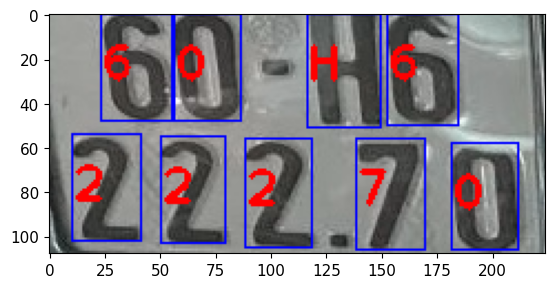

In [ ]:
results = yolo_license_plate(img)
bb_list = results.pandas().xyxy[0].values.tolist()
if len(bb_list) == 0 or len(bb_list) < 7 or len(bb_list) > 11:
    print("unknown")

print (bb_list)
for i in range(0,len(bb_list)):
  cv2.rectangle(img, (int(bb_list[i][0]),int(bb_list[i][1])), (int(bb_list[i][2]),int(bb_list[i][3])), color = (0,0,255), thickness = 1)
  cv2.putText(img, str(bb_list[i][6]), (int(bb_list[i][0]), int(bb_list[i][1])+30), cv2.FONT_HERSHEY_PLAIN, 1.5, (255,0,0), 2)
plt.imshow(img)
plt.show()

In [ ]:
center_list = []
y_mean = 0
y_sum = 0
for bb in bb_list:
    x_c = (bb[0]+bb[2])/2
    y_c = (bb[1]+bb[3])/2
    y_sum += y_c
    center_list.append([x_c,y_c,bb[-1]])
y_mean = int(y_sum) / len(bb_list)

line_1 = []
line_2 = []
license_plate = ""
for c in center_list:
     if int(c[1]) > y_mean:
        line_2.append(c)
     else:
        line_1.append(c)

for l1 in sorted(line_1, key = lambda x: x[0]):
        license_plate += str(l1[2])
license_plate += "-"
for l2 in sorted(line_2, key = lambda x: x[0]):
        license_plate += str(l2[2])
print(license_plate)

60H6-22270


In [ ]:
def read_plate(yolo_license_plate, im):
    results = yolo_license_plate(im)
    bb_list = results.pandas().xyxy[0].values.tolist()
    if len(bb_list) == 0 or len(bb_list) < 7 or len(bb_list) > 11:
        return "unknown"
    center_list = []
    y_mean = 0
    y_sum = 0
    for bb in bb_list:
        x_c = (bb[0]+bb[2])/2
        y_c = (bb[1]+bb[3])/2
        y_sum += y_c
        center_list.append([x_c,y_c,bb[-1]])
    y_mean = int(y_sum) / len(bb_list)

    line_1 = []
    line_2 = []
    license_plate = ""
    for c in center_list:
         if int(c[1]) > y_mean:
            line_2.append(c)
         else:
            line_1.append(c)
    for l1 in sorted(line_1, key = lambda x: x[0]):
            license_plate += str(l1[2])
    license_plate += "-"
    for l2 in sorted(line_2, key = lambda x: x[0]):
            license_plate += str(l2[2])
    return license_plate


SAU ĐÂY LÀ CODE CHẠY TỔNG QUÁT CỦA MÔ HÌNH EM:
  1. Chạy với tập ảnh test

In [ ]:
testfolderpath = '/content/drive/MyDrive/FinalProject_cs114/Testfolder'

image_files = [f for f in os.listdir(testfolderpath) if f.endswith(('.jpg', '.jpeg', '.png'))]

i = -1
for image_file in image_files:
  img_path = os.path.join(testfolderpath, image_file)
  i+=1
  # Đọc ảnh từ đường dẫn
  img = cv2.imread(img_path)
  if img is None:
    print(f"Không thể đọc hình ảnh từ đường dẫn")
  else:
    plates = yolo_LP_detect(img,size = 640)
    list_plates = plates.pandas().xyxy[0].values.tolist()
    list_read_plates = set()
    if len(list_plates) == 0:
      lp = read_plate(yolo_license_plate,img)
      if lp != "unknown":
          cv2.putText(img, lp, (7, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
          list_read_plates.add(lp)
    else:
      for plate in list_plates:
          flag = 0
          x = int(plate[0]) # xmin
          y = int(plate[1]) # ymin
          w = int(plate[2] - plate[0]) # xmax - xmin
          h = int(plate[3] - plate[1]) # ymax - ymin
          crop_img = img[y:y+h, x:x+w]
          cv2.rectangle(img, (int(plate[0]),int(plate[1])), (int(plate[2]),int(plate[3])), color = (0,0,225), thickness = 2)
          try:
            cv2.imwrite(f"/content/drive/MyDrive/FinalProject_cs114/crop/{image_file}", crop_img)
          except Exception as e:
            print(f"Lỗi khi ghi ảnh: {e}")
          crop_img = cv2.imread(f"/content/drive/MyDrive/FinalProject_cs114/crop/{image_file}")
          lp = ""
          for cc in range(0,2):
              for ct in range(0,2):
                  lp = read_plate(yolo_license_plate, deskew(crop_img, cc, ct))
                  if lp != "unknown":
                      list_read_plates.add(lp)
                      cv2.putText(img, lp, (int(plate[0]), int(plate[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 2, (36,255,12), 2)
                      cv2.imwrite(f"/content/drive/MyDrive/FinalProject_cs114/result/{image_file}", img)
                      flag = 1
                      break
              if flag == 1:
                  break


  2. Chạy với từng ảnh

0 0


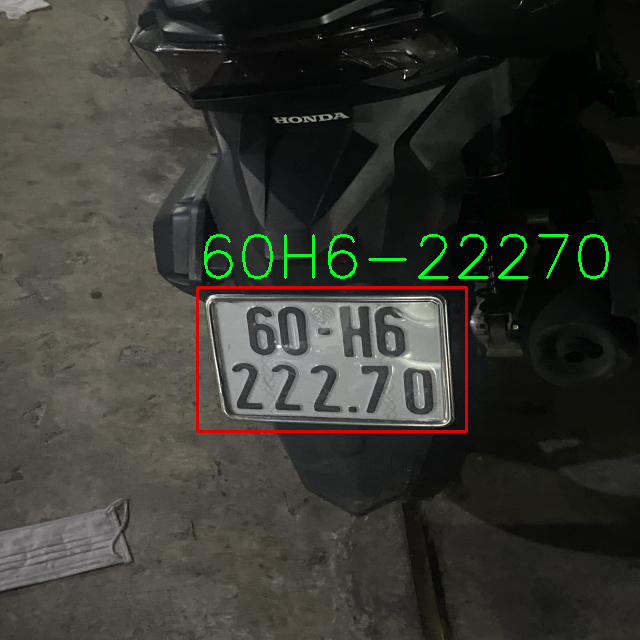

In [ ]:
img = cv2.imread('/content/drive/MyDrive/FinalProject_cs114/Testfolder/xemay (1).jpg')
plates = yolo_LP_detect(img, size=640)
list_plates = plates.pandas().xyxy[0].values.tolist()
list_read_plates = set()
if len(list_plates) == 0:
    lp = read_plate(yolo_license_plate,img)
    if lp != "unknown":
        cv2.putText(img, lp, (7, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        list_read_plates.add(lp)
else:
    for plate in list_plates:
        flag = 0
        x = int(plate[0]) # xmin
        y = int(plate[1]) # ymin
        w = int(plate[2] - plate[0])# xmax - xmin
        h = int(plate[3] - plate[1]) # ymax - ymin
        crop_img = img[y:y+h, x:x+w]
        cv2.imwrite(f"/content/drive/MyDrive/FinalProject_cs114/crop/crop{0}.jpg", crop_img)
        cv2.rectangle(img, (int(plate[0]),int(plate[1])), (int(plate[2]),int(plate[3])), color = (0,0,225), thickness = 2)
        lp = ""
        crop_img = cv2.imread('/content/drive/MyDrive/FinalProject_cs114/crop/crop0.jpg')
        for cc in range(0,2):
            for ct in range(0,2):
                lp = read_plate(yolo_license_plate, deskew(crop_img, cc, ct))
                if lp != "unknown":
                    list_read_plates.add(lp)
                    cv2.putText(img, lp, (int(plate[0]), int(plate[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 2, (36,255,12), 2)
                    flag = 1
                    print(cc,ct)
                    break
            if flag == 1:
                break

cv2_imshow(img)


BỔ SUNG: VIỆC ĐỌC BIỂN SỐ BẰNG THƯ VIỆN EASYOCR

In [ ]:
!pip install easyocr

Thực hiện việc cắt các hình biển số và giảm các góc cạnh để chỉ lấy các chữ số mà không lấy khung biển số.

In [ ]:
testfolderpath = '/content/drive/MyDrive/FinalProject_cs114/Testfolder'

image_files = [f for f in os.listdir(testfolderpath) if f.endswith(('.jpg', '.jpeg', '.png'))]

i = -1
for image_file in image_files:
  img_path = os.path.join(testfolderpath, image_file)
  i+=1
  # Đọc ảnh từ đường dẫn
  img = cv2.imread(img_path)
  if img is None:
    print(f"Không thể đọc hình ảnh từ đường dẫn")
  else:
    plates = yolo_LP_detect(img,size = 640)
    list_plates = plates.pandas().xyxy[0].values.tolist()
    list_read_plates = set()
    if len(list_plates) == 0:
      lp = read_plate(yolo_license_plate,img)
      if lp != "unknown":
          cv2.putText(img, lp, (7, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
          list_read_plates.add(lp)
    else:
      for plate in list_plates:
          flag = 0
          x = int(plate[0])+25 # xmin
          y = int(plate[1])+10 # ymin
          w = int(plate[2] - plate[0])-45 # xmax - xmin
          h = int(plate[3] - plate[1])-20 # ymax - ymin
          crop_img = img[y:y+h, x:x+w]
          try:
           cv2.imwrite(f"/content/drive/MyDrive/FinalProject_cs114/crop/{image_file}", crop_img)
          except Exception as e:
            print(f"Lỗi khi ghi ảnh: {e}")


Lỗi khi ghi ảnh: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

Lỗi khi ghi ảnh: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

Lỗi khi ghi ảnh: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:787: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



THỰC HIỆN VIỆC ĐỌC BIỂN SỐ BẰNG THƯ VIỆN

In [ ]:
import easyocr
reader = easyocr.Reader(['en'])  # Chọn ngôn ngữ, ví dụ: 'en' cho tiếng Anh

ĐỌC CÁC BIỂN SỐ ĐƯỢC CẮT RA VÀ LƯU VÀO FOLDER ĐỂ SO SÁNH

In [ ]:
testfolderpath = '/content/drive/MyDrive/FinalProject_cs114/crop'

image_files = [f for f in os.listdir(testfolderpath) if f.endswith(('.jpg', '.jpeg', '.png'))]
i = -1
for image_file in image_files:
  img_path = os.path.join(testfolderpath, image_file)
  i+=1
  img = cv2.imread(img_path)
  result = reader.readtext(img)
  # Xử lý chuỗi để lấy tên file không kèm đuôi mở rộng (extension)
  base_filename, _ = os.path.splitext(image_file)
  # Đổi tên file thành 'abc.txt'
  new_filename = base_filename + '.txt'
  file_path= f'/content/drive/MyDrive/FinalProject_cs114/easyocr/{new_filename}'
  if len(result) == 2:
    content=result[0][1]+' '+result[1][1]
  else:
    content = 'error'
  with open(file_path, 'w') as file:
    file.write(content)
